<a href="https://colab.research.google.com/github/hsym-uec/myWeb_github/blob/main/Simmple_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# SoftBank Stock data from Stooq.com 
# reference https://seanmemo.com/234/

import tkinter as tk
import mplfinance as mpf
import datetime
from datetime import timedelta
from pandas_datareader import data
global df

def btn_click():
    global df
    days = txt.get()
    #days = input("範囲指定:")
    today = datetime.date.today()
    start = today - timedelta(float(days))
    end = today
    df = data.DataReader('7974.JP', 'stooq', start, end)
    

root = tk.Tk()
root.title("株価表示")
root.geometry("300x200")

lbl = tk.Label(text='範囲')
lbl.place(x=30, y=70)

txt = tk.Entry(width=20)
txt.place(x=90, y=70)

btn = tk.Button(text='計算', command=btn_click)
btn.place(x=140, y=170)

root.mainloop()

In [10]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2023-05-23,6060,6107,5934,5988,7209500
2023-05-22,5999,6060,5989,6060,5098500
2023-05-19,6074,6082,5968,5977,6094600
2023-05-18,6048,6063,5998,6043,8556600
2023-05-17,5880,5966,5861,5925,7467500
...,...,...,...,...,...
2023-02-17,5488,5499,5425,5456,4440300
2023-02-16,5432,5499,5391,5498,6867300
2023-02-15,5370,5374,5305,5336,4432200


<Axes: xlabel='Date'>

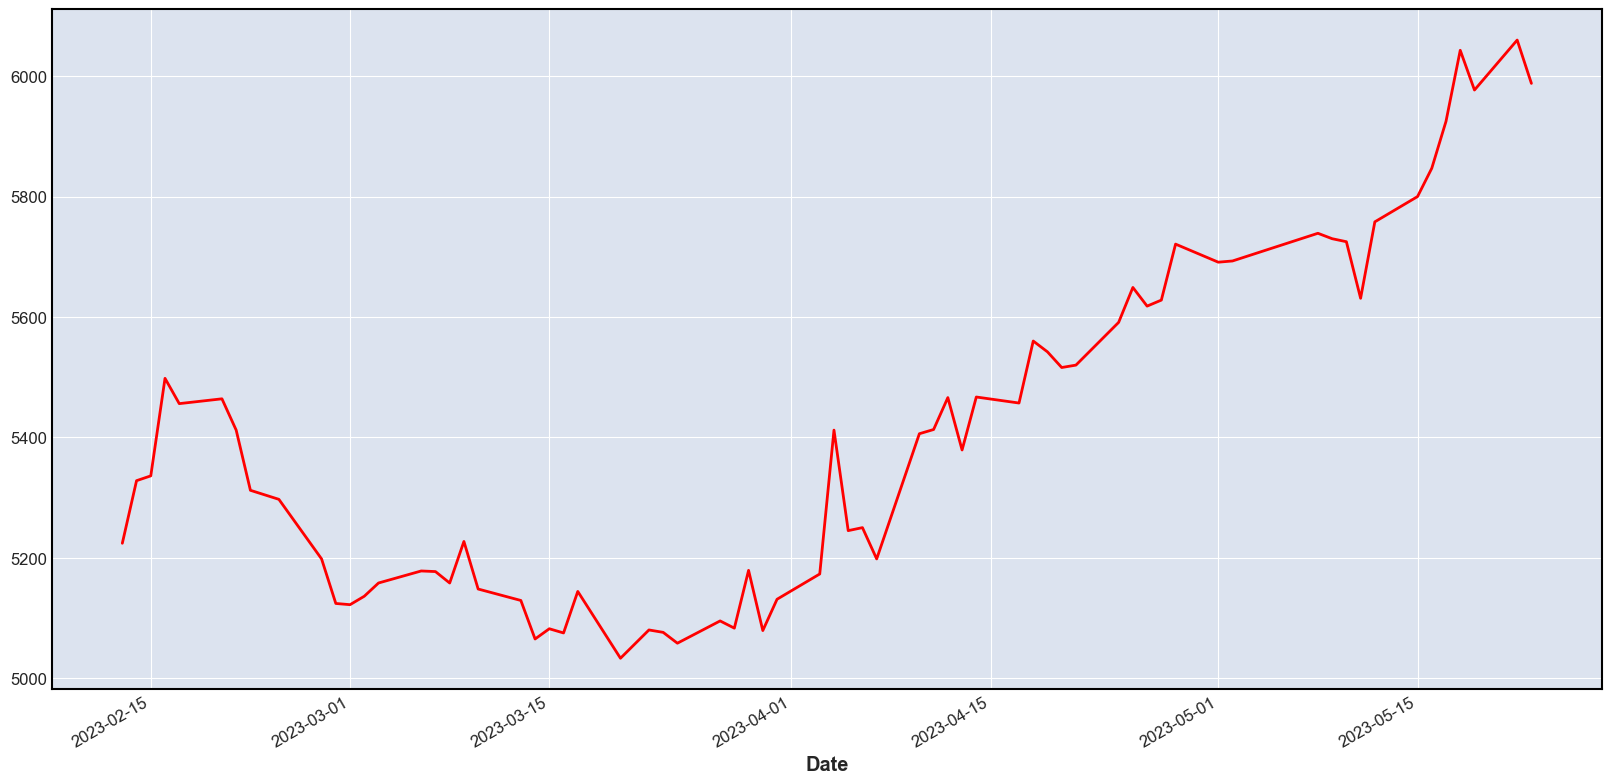

In [11]:
df["Close"].plot(figsize=(20,10), color="red")

In [12]:
# 前日と前々日の差額
df["Close"][0] - df["Close"][1]

-72

In [13]:
df["Close"]["2023-05-16"]

5847

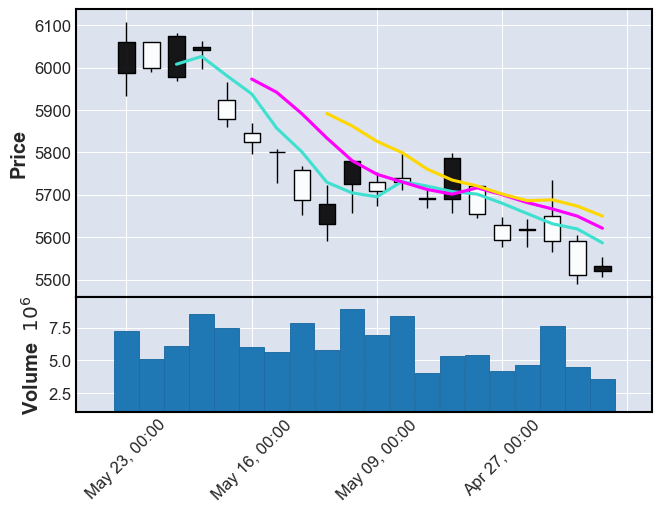

In [14]:
mpf.plot(df[:20],type='candle',mav=(3, 6, 9),volume=True)